In [4]:
import base64
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import json
import seaborn as sns
import re

pp = pprint.PrettyPrinter(indent=4)

In [104]:
remove_negative_gaze = False

filter_blacklist = True
blacklist = ['a']

df = pd.read_csv('data/experiment_results_public_lab.csv')
df = df.drop('type', axis=1)

if filter_blacklist:
    df = df[~df.workerid.isin(blacklist)]

# reindex the df
df.reset_index(drop=True, inplace=True)

def parse(data):
    while data[0] != '{':
        data = data[1:]
    while data[-1] != '}':
        data = data[:-1]
    data = data.replace('\\', '')
    data = re.sub(
        r'(?<=strategy":")(.*)(?="\})',
        lambda m: m.group(0).replace('"', '\\"'),
        data,
        count=1)
    json_data = {}
    try:
        json_data = json.loads(data)
    except:
        pp.pprint(data[-200:])
    return json_data

df = pd.concat([df, pd.json_normalize(df.apply(lambda x: parse(x['answer']), axis=1, ), max_level=0)], axis=1)

if remove_negative_gaze:
    df.gaze = df.gaze.apply(lambda x: {key:val for key, val in json.loads(base64.b64decode(x)).items() if int(key) > 0})
else:
    df.gaze = df.gaze.apply(lambda x: json.loads(base64.b64decode(x)))
df.sort_values(by=['workerid', 'userTrialId'], inplace=True)
df.reset_index(drop=True, inplace=True)
df['deviceInfo'] = df['deviceInfo'].ffill()
df.columns

Index(['filename', 'listnumber', 'assignmentid', 'hitid', 'workerid', 'origin',
       'timestamp', 'partid', 'questionid', 'answer', 'trialid', 'sentmsg',
       'trgt', 'comp', 'dist', 'msg1', 'msg2', 'msg3', 'msg4', 'id',
       'sent_msg', 'objs', 'trgtPos', 'compPos', 'distPos', 'type',
       'msgsOrder', 'userTrialId', 'deviceInfo', 'calibrationPrecision',
       'answerTime', 'choicePos', 'choice', 'coordinates', 'gaze', 'correct',
       'techDiffs', 'otherComments', 'strategy'],
      dtype='object')

## Gen Features

{   'browser': 'Chrome',
    'browserMajorVersion': 131,
    'browserVersion': '131.0.0.0',
    'mobile': False,
    'os': 'Mac OS X',
    'osVersion': '10_15_7',
    'screen': '1470 x 956'}
[1470, 956]
{   'available_msgs': {'height': 100, 'width': 400, 'x': 535, 'y': 674},
    'img1': {'height': 200, 'width': 200, 'x': 205, 'y': 332},
    'img2': {'height': 200, 'width': 200, 'x': 635, 'y': 332},
    'img3': {'height': 200, 'width': 200, 'x': 1065, 'y': 332},
    'msg1': {'height': 100, 'width': 100, 'x': 535, 'y': 674},
    'msg2': {'height': 100, 'width': 100, 'x': 635, 'y': 674},
    'msg3': {'height': 100, 'width': 100, 'x': 735, 'y': 674},
    'msg4': {'height': 100, 'width': 100, 'x': 835, 'y': 674},
    'sent_msg': {'height': 100, 'width': 100, 'x': 826, 'y': 118}}


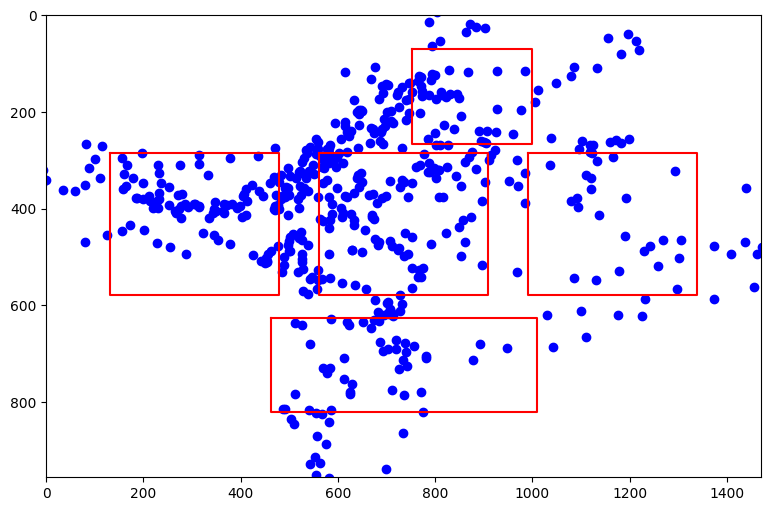

First row of new features

timeOnSentMsg                            36
timeOnAvailableMsgs                      43
timeOnImg1                               90
timeOnImg2                              108
timeOnImg3                               24
timeOnTrgt                               90
timeOnDist                               24
timeOnComp                              108
distPos                                   2
trgtPos                                   0
compPos                                   1
timeOnAOI                               301
proportionalTimeOnSentMsg          0.119601
proportionalTimeOnAvailableMsgs    0.142857
proportionalTimeOnTrgt             0.299003
proportionalTimeOnDist             0.079734
proportionalTimeOnComp             0.358804
Name: 0, dtype: object


In [105]:
df['meanAnswerTime'] = df.groupby('workerid')['answerTime'].transform('mean')
df['answerAccuracy'] = df.groupby('workerid')['correct'].transform('mean')
df['resolution'] = df.deviceInfo.apply(lambda x: [int(size) for size in x['screen'].split('x')])

# margin for gaze objects
res_w_x = 0.05
res_w_y = 0.05

first_ploted = False
plot_first = True

if plot_first:
    resolution = df.iloc[0].resolution
    pp.pprint(df.iloc[0].deviceInfo)
    pp.pprint(resolution)
    plt.figure(figsize=(resolution[0]*6/resolution[1], 6))
    plt.xlim(0, resolution[0])
    plt.ylim(0, resolution[1])
    for _, val in df.iloc[0].gaze.items():
            plt.plot(val['x'], val['y'], 'bo')

def count_gaze(gaze, coords, resolution, plot_first = plot_first):
    global first_ploted
    margin_x = res_w_x * resolution[0]
    margin_y = res_w_y * resolution[1]
    x_min = max(0, coords['x'] - margin_x)
    x_max = coords['x'] + coords['width'] + margin_x
    y_min = max(0, coords['y'] - margin_y)
    y_max = coords['y'] + coords['height'] + margin_y
    if plot_first and not first_ploted:
        plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 'r')
        first_ploted = True
    count = 0
    for _, val in gaze.items():
        if x_min <= val['x'] <= x_max and y_min <= val['y'] <= y_max:
            count += 1
    return count

def merge_msgs_coords(coords):
    coords['available_msgs'] = {'height': coords['msg1']['height'], 'width': coords['msg4']['x'] + coords['msg4']['width'] - coords['msg1']['x'], 'x': coords['msg1']['x'], 'y': coords['msg1']['y']}
    return coords

df['coordinates'] = df.apply(lambda x: merge_msgs_coords(x['coordinates']), axis=1)
pp.pprint(df.iloc[0].coordinates)

df['timeOnSentMsg'] = df.apply(lambda x: count_gaze(x['gaze'], x['coordinates']['sent_msg'], x['resolution']), axis=1) 
first_ploted = False
df['timeOnAvailableMsgs'] = df.apply(lambda x: count_gaze(x['gaze'], x['coordinates']['available_msgs'], x['resolution']), axis=1)
first_ploted = False
df['timeOnImg1'] = df.apply(lambda x: count_gaze(x['gaze'], x['coordinates']['img1'], x['resolution']), axis=1)
first_ploted = False
df['timeOnImg2'] = df.apply(lambda x: count_gaze(x['gaze'], x['coordinates']['img2'], x['resolution']), axis=1)
first_ploted = False
df['timeOnImg3'] = df.apply(lambda x: count_gaze(x['gaze'], x['coordinates']['img3'], x['resolution']), axis=1)
df['timeOnTrgt'] = df.apply(lambda x: x[('timeOnImg' + str(1 + x['trgtPos']))], axis=1)
df['timeOnDist'] = df.apply(lambda x: x[('timeOnImg' + str(1 + x['distPos']))], axis=1)
df['timeOnComp'] = df.apply(lambda x: x[('timeOnImg' + str(1 + x['compPos']))], axis=1)
df['timeOnAOI'] = df.apply(lambda x: sum(x[['timeOnSentMsg', 'timeOnAvailableMsgs', 'timeOnImg1', 'timeOnImg2', 'timeOnImg3']]), axis=1)
df['proportionalTimeOnSentMsg'] = df['timeOnSentMsg'] / df['timeOnAOI']
df['proportionalTimeOnAvailableMsgs'] = df['timeOnAvailableMsgs'] / df['timeOnAOI']
df['proportionalTimeOnTrgt'] = df['timeOnTrgt'] / df['timeOnAOI']
df['proportionalTimeOnDist'] = df['timeOnDist'] / df['timeOnAOI']
df['proportionalTimeOnComp'] = df['timeOnComp'] / df['timeOnAOI']

if plot_first:
    plt.gca().invert_yaxis()
    plt.show()

print("First row of new features\n")
pp.pprint(df.iloc[0][['timeOnSentMsg', 'timeOnAvailableMsgs', 'timeOnImg1', 'timeOnImg2', 'timeOnImg3', 'timeOnTrgt', 'timeOnDist', 'timeOnComp', 'distPos', 'trgtPos', 'compPos', 'timeOnAOI', 'proportionalTimeOnSentMsg', 'proportionalTimeOnAvailableMsgs', 'proportionalTimeOnTrgt', 'proportionalTimeOnDist', 'proportionalTimeOnComp']])

## Final Feature CSV

In [116]:
final_df = df.groupby('workerid')[['timeOnSentMsg', 'timeOnAvailableMsgs', 'timeOnTrgt', 'timeOnDist', 'timeOnComp', 'timeOnAOI', 'proportionalTimeOnSentMsg', 'proportionalTimeOnAvailableMsgs', 'proportionalTimeOnTrgt', 'proportionalTimeOnDist', 'proportionalTimeOnComp', 'meanAnswerTime', 'answerAccuracy']].mean()
final_df['simpleAccuracy'] = df[df['type'].isin(['simple', 'strategy_simple'])].groupby('workerid')['correct'].mean()
final_df['complexAccuracy'] = df[df['type'].isin(['complex', 'strategy_complex'])].groupby('workerid')['correct'].mean()
final_df['unambiguousAccuracy'] = df[df['type'] == 'unambiguous'].groupby('workerid')['correct'].mean()
final_df['calibrationPrecision'] = df.groupby('workerid')['calibrationPrecision'].first()


# Save the final df
final_df.to_csv('data/final_df.csv')

In [ ]:
df

##  Leaderboard

In [6]:
leaderboard_df = df.sort_values(by='meanAnswerTime').sort_values(by='answerAccuracy', ascending=False, kind='stable')[['workerid', 'answerAccuracy', 'meanAnswerTime']].drop_duplicates().reset_index(drop=True)
leaderboard_df.index += 1
pp.pprint(leaderboard_df)

   workerid  answerAccuracy  meanAnswerTime
1  veratest        1.000000     4637.857143
2   test_ee        1.000000     7021.571429
3     Laura        1.000000     9484.285714
4    varsha        1.000000    23598.928571
5      Olha        1.000000    37141.214286
6     merel        0.928571     7431.071429
7  test_iza        0.928571    11653.642857


{   'browser': 'Chrome',
    'browserMajorVersion': 131,
    'browserVersion': '131.0.0.0',
    'mobile': False,
    'os': 'Mac OS X',
    'osVersion': '10_15_7',
    'screen': '1470 x 956'}
[88, 73, 83]
simple


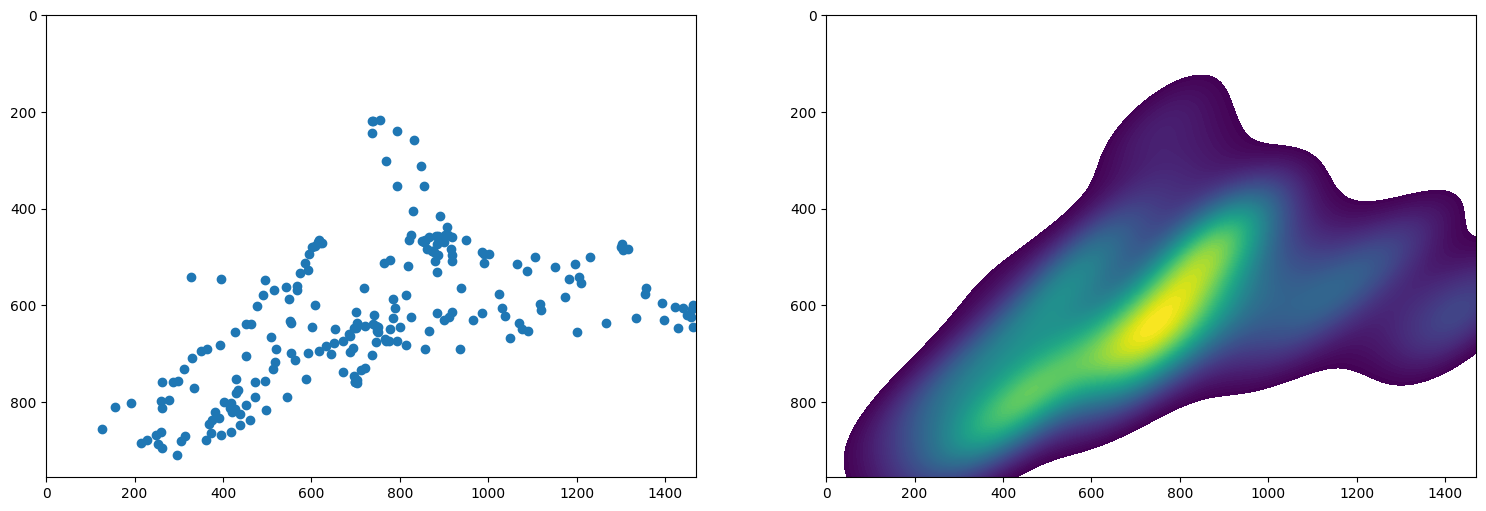

simple


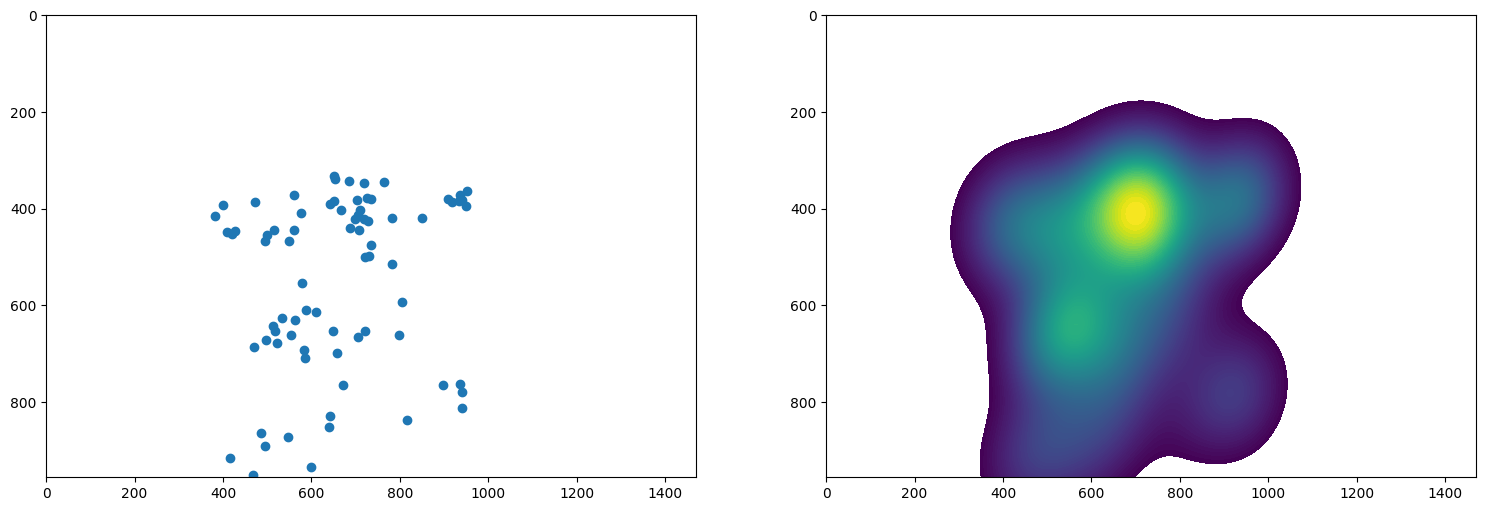

complex


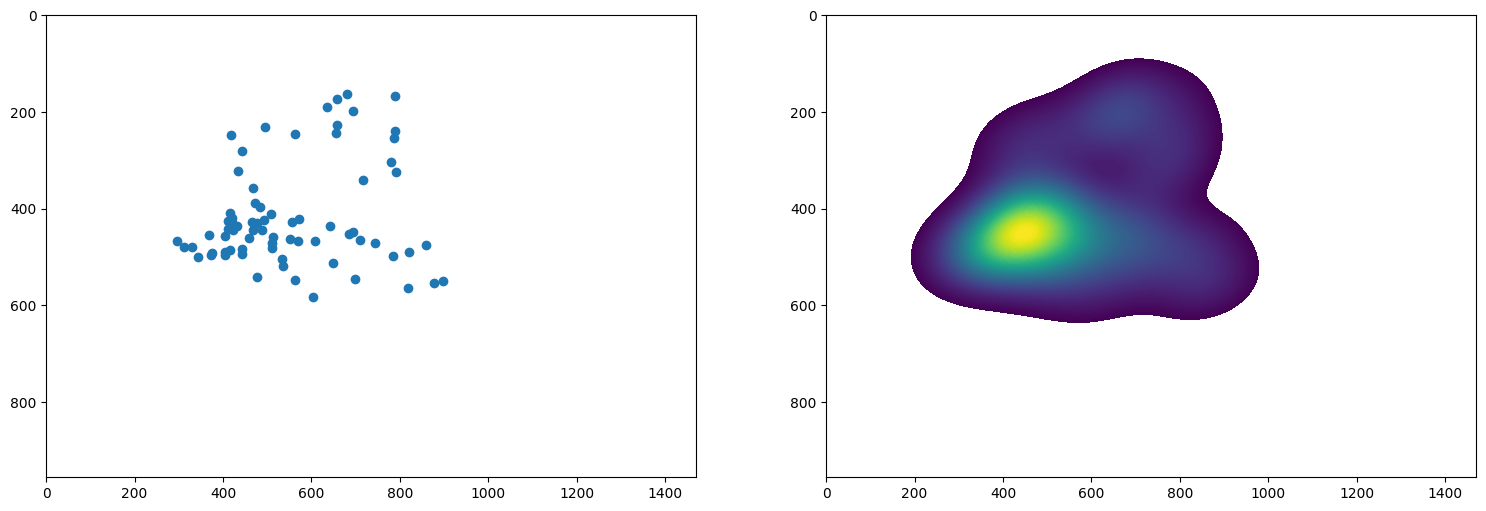

unambiguous


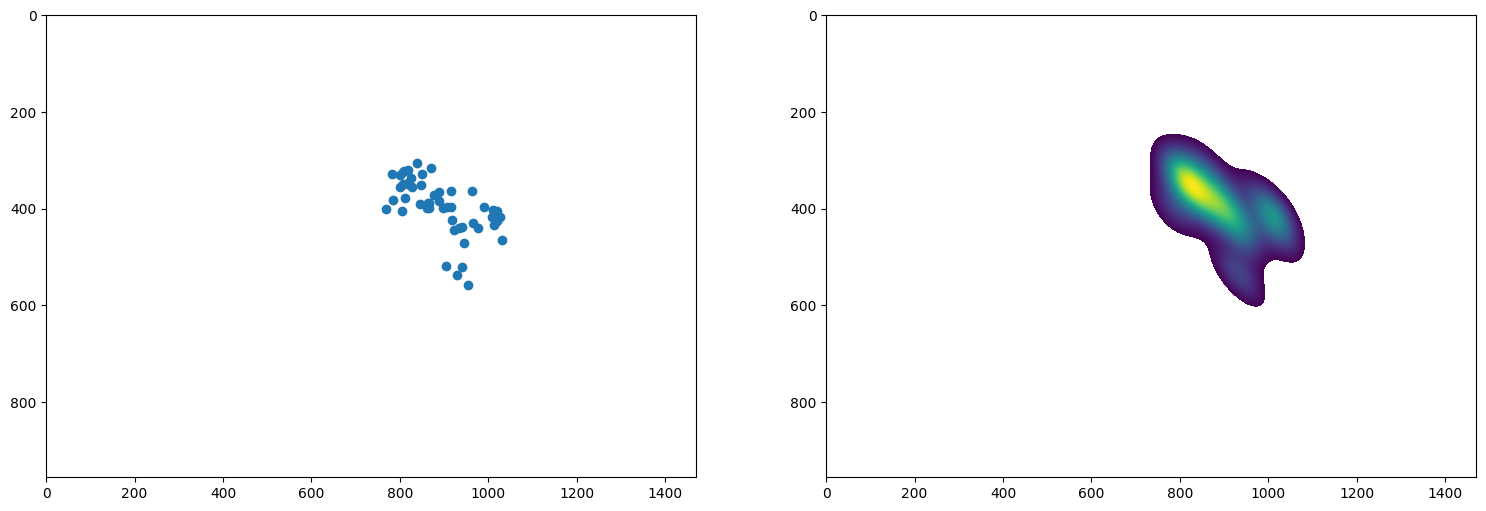

unambiguous


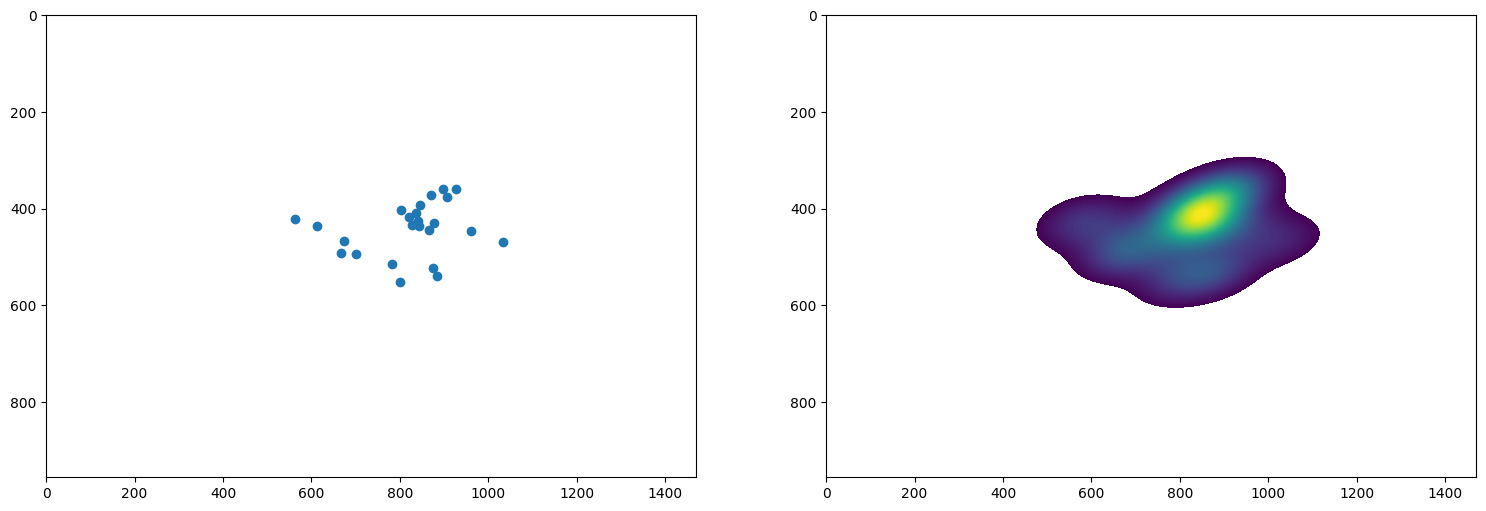

unambiguous


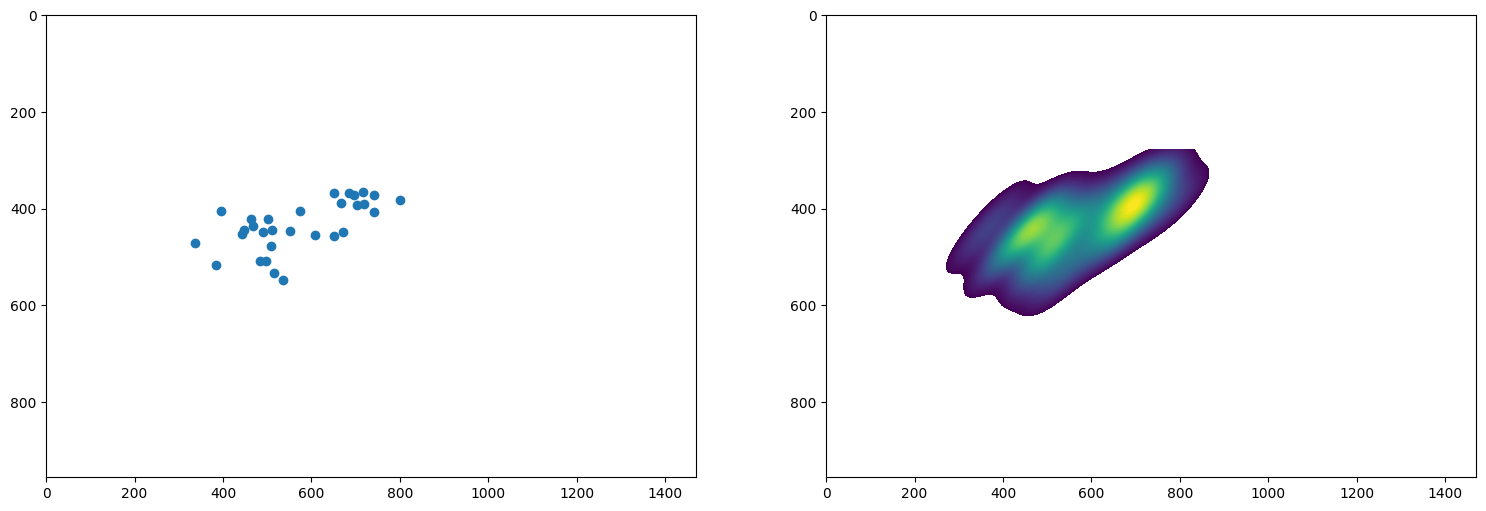

simple


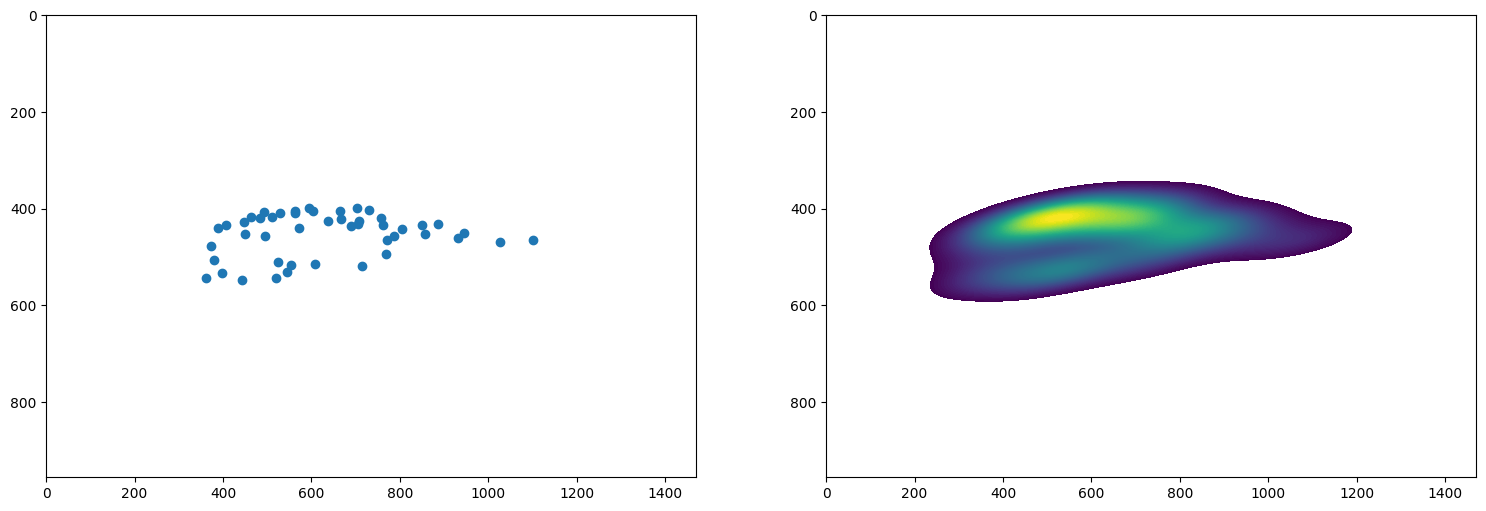

complex


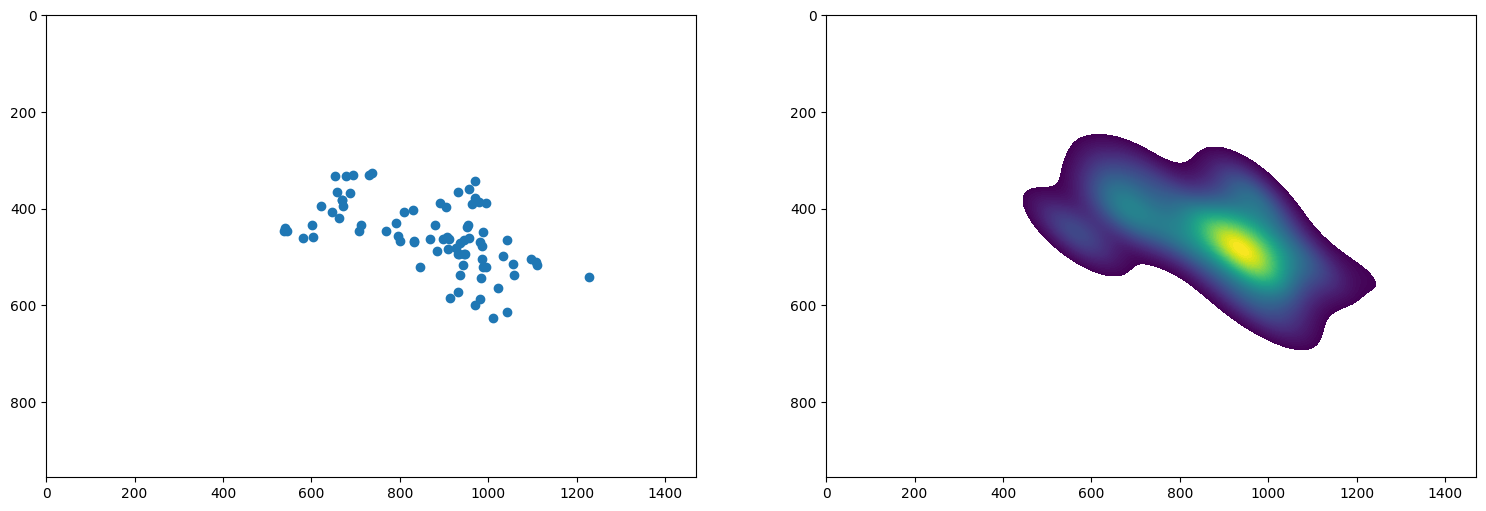

simple


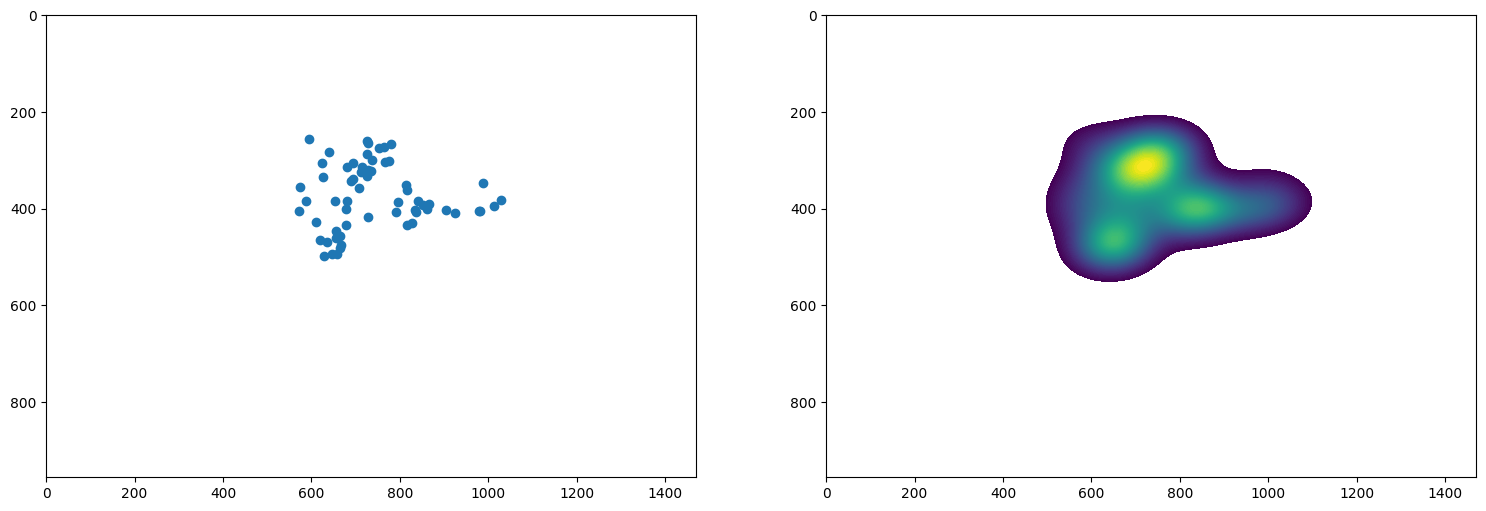

complex


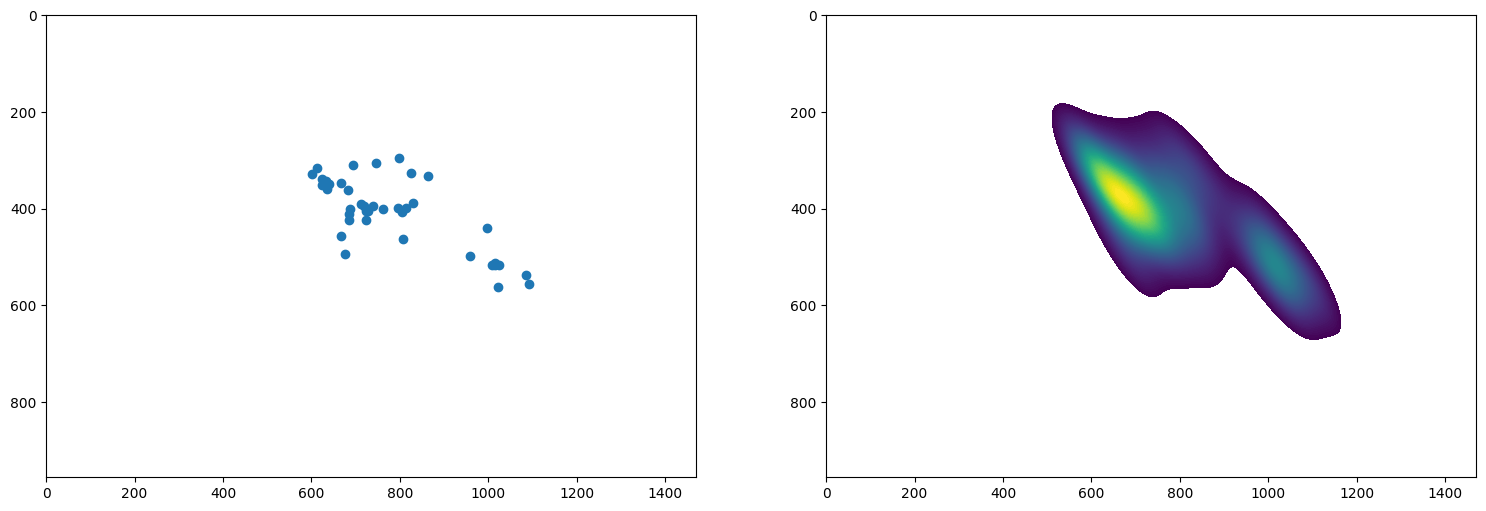

unambiguous


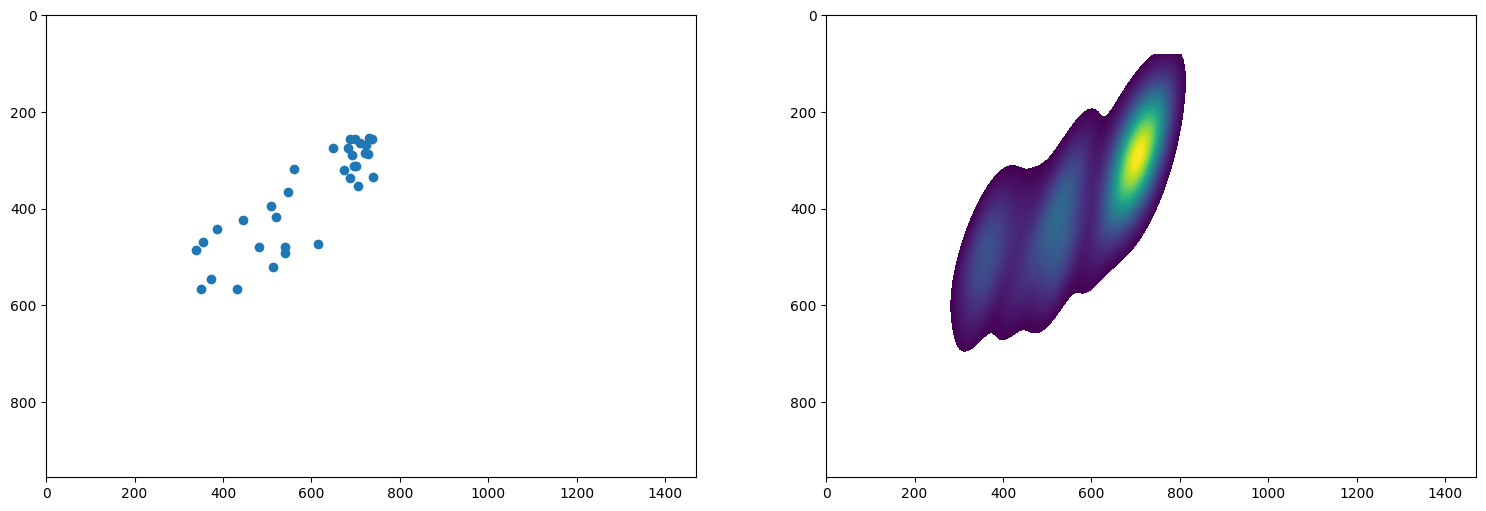

complex


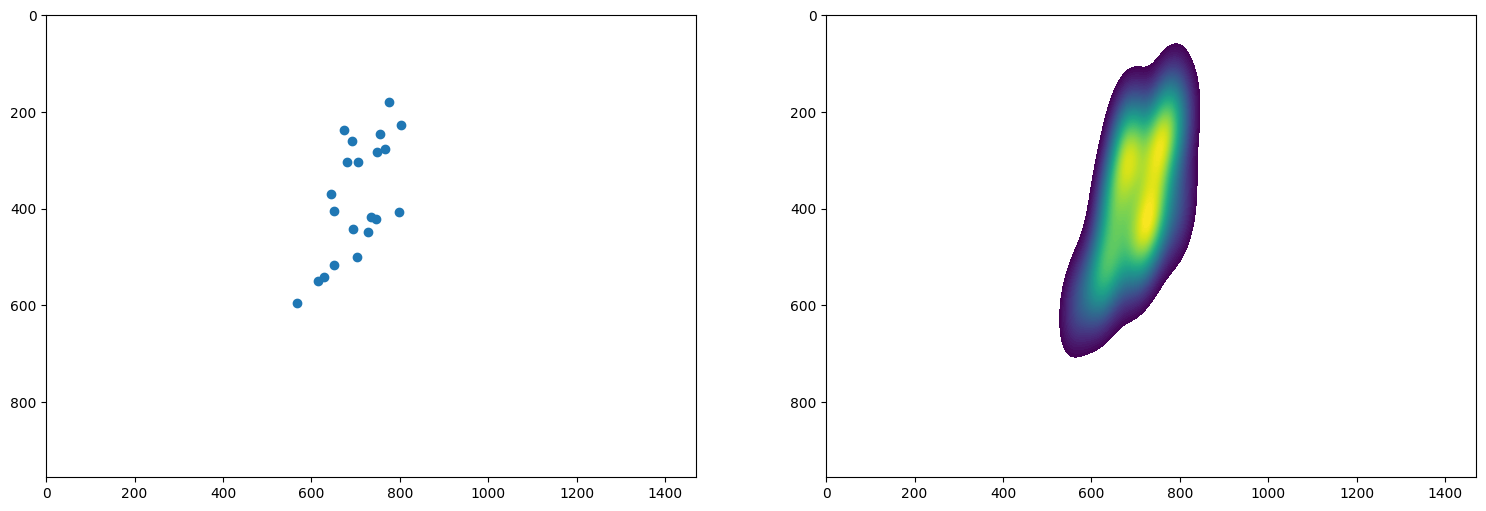

In [115]:
sample = df[df['workerid']=='veratest']
pp.pprint(sample.iloc[0].deviceInfo)
pp.pprint(sample.iloc[0].calibrationPrecision)
resolution = sample.iloc[0].resolution

for i in range(12):
    cur_sample = sample.iloc[i]
    gaze_sample = cur_sample.gaze
    x = np.array([g['x'] for g in gaze_sample.values()])
    y = np.array([g['y'] for g in gaze_sample.values()])
    # print(len(x))
    # print(cur_sample.answerTime)
    print(cur_sample.type)
    # make a scatterplot on the left and a heatmap on the right, keep proportions of the screen
    fig, axs = plt.subplots(1, 2, figsize=(2*(resolution[0]*6/resolution[1]), 6))
    axs[0].scatter(x, y)
    axs[0].set_xlim(0, resolution[0])
    axs[0].set_ylim(0, resolution[1])
    axs[0].invert_yaxis()
    sns.kdeplot(x=x, y=y, ax=axs[1], fill=True, cmap='viridis', levels=100)
    axs[1].set_xlim(0, resolution[0])
    axs[1].set_ylim(0, resolution[1])
    axs[1].invert_yaxis()

    plt.show()